# Secret Manager Function

In [1]:
import boto3
from botocore.exceptions import ClientError
import json

def get_secret(secret_name):
    region_name = "us-east-1"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        raise e

    secret = get_secret_value_response['SecretString']
    
    return json.loads(secret)

# Connecting to Database

In [2]:
import psycopg2

conn = psycopg2.connect(host=get_secret('postgresql')['host'],
                      user=get_secret('postgresql')['username'],
                      password = get_secret('postgresql')['password'],
                      dbname=get_secret('postgresql')['engine'])

cur = conn.cursor()

# Q1

In [3]:
import warnings

warnings.simplefilter('ignore')

## Pull fips for state

In [5]:
import pandas as pd

sql_fips = """
SELECT fips, name
FROM name
WHERE name = 'New York';
"""

ny_fips = pd.read_sql(sql_fips, conn)
print(ny_fips)


  fips      name
0   36  New York


## Pull yearly population data

In [13]:
sql_population_fips = f"""
SELECT year, pop
FROM population
WHERE fips = '36'
ORDER BY year ASC;
"""

ny_df = pd.read_sql(sql_population_fips, conn)
ny_df.head()


,year,pop
0,2005,18655275
1,2006,19306183
2,2007,19297729
3,2008,19490297
4,2009,19541453


## Use Jupyter AI to calculate and plot growth rate

In [7]:
! pip install jupyter-ai-magics[all] -q

In [8]:
import os
os.environ["OPENAI_API_KEY"] = get_secret('openai_1')['api_key']

In [9]:
%load_ext jupyter_ai_magics

In [14]:
%%ai gpt4 -f code
Calculate the growth rate with the data provided in {ny_df}, use the ny_df directly, and visualize the result on a line chart

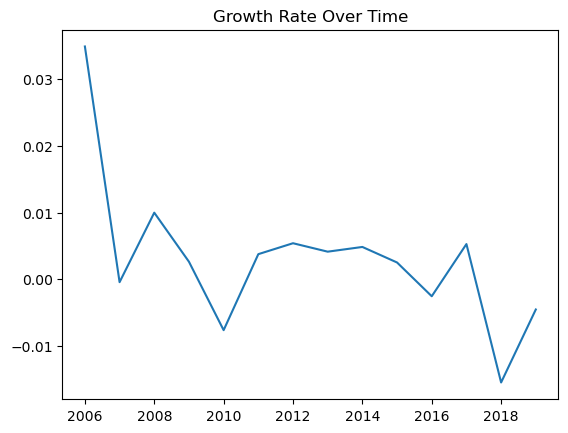

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

data = { 'year':[2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019], 'pop': [18655275,19306183,19297729,19490297,19541453,19392283,19465197,19570261,19651127,19746227,19795791,19745289,19849399,19542209,19453561] }

ny_df = pd.DataFrame(data)
ny_df['growth_rate'] = ny_df['pop'].pct_change()

plt.plot(ny_df['year'], ny_df['growth_rate'])
plt.title('Growth Rate Over Time')
plt.show()